In [3]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import math
from tqdm import tqdm
import glob
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import cv2 as cv
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

from skopt import BayesSearchCV
from bayes_opt import BayesianOptimization

파라미터 셋팅

In [4]:
start_time = time.time()
# Parameters
patch_stride = 16
K = 20

데이터 로드

In [9]:
# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

Load Dataset ...


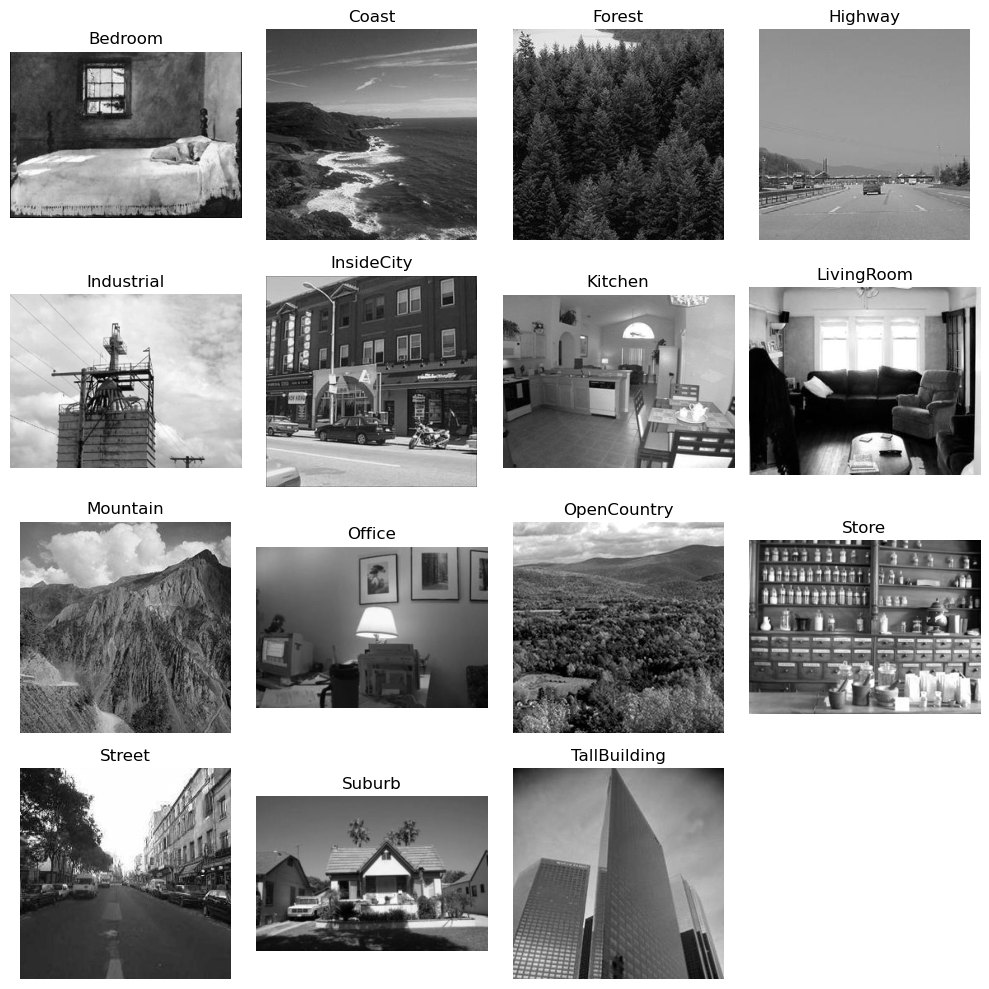

In [10]:
# Load Dataset
x_train, y_train, x_test, y_test, labels_names = scene15()

# label별 이미지 한장
label_image_dict = {}
for img, label in zip(x_train, y_train):
    if label not in label_image_dict:
        label_image_dict[label] = img

# Plot one image per label
fig = plt.figure(figsize=(10, 10))

for i, (label, img) in enumerate(label_image_dict.items()):
    ax = fig.add_subplot(4, 4, i+1)  # Adjust grid size (4, 4) as per the number of unique labels
    ax.imshow(img, cmap='gray')
    ax.set_title(labels_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

패치 추출
- 이미지를 patch_stride 크기의 패치로 나눔
- 각 패치 중심점에 해당하는 키 포인트를 추출하여 리스트에 저장
- 이미지의 너비와 높이를 patch_stride로 나눈 값(즉, 패치의 개수)을 특징 형태 리스트에 추가


In [11]:
# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

특징 추출(SIFT): SIFT(Scale-Invariant Feature Transform)로 이미지 특징점 추출
- SIFT() 함수:  SIFT 객체 생성 후, 키포인트&디스크립터 추출
- 이미지를 순회하면서 해당 이미지와 이미지의 키 포인트를 SIFT() 함수에 넘겨 디스크립터를 추출


In [12]:
# Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

Extract Train Features ...    1/1538
Extract Train Features ...    2/1538
Extract Train Features ...    3/1538
Extract Train Features ...    4/1538
Extract Train Features ...    5/1538
Extract Train Features ...    6/1538
Extract Train Features ...    7/1538
Extract Train Features ...    8/1538
Extract Train Features ...    9/1538
Extract Train Features ...   10/1538
Extract Train Features ...   11/1538
Extract Train Features ...   12/1538
Extract Train Features ...   13/1538
Extract Train Features ...   14/1538
Extract Train Features ...   15/1538
Extract Train Features ...   16/1538
Extract Train Features ...   17/1538
Extract Train Features ...   18/1538
Extract Train Features ...   19/1538
Extract Train Features ...   20/1538
Extract Train Features ...   21/1538
Extract Train Features ...   22/1538
Extract Train Features ...   23/1538
Extract Train Features ...   24/1538
Extract Train Features ...   25/1538
Extract Train Features ...   26/1538
Extract Train Features ...   27/1538
E

특징(피처) 정규화 : PCA(Principal Component Analysis) 이용해서 특징들의 정규화
- 데이터셋 특징들을 모두 연결하여 하나의 큰 배열 생성
- 각 특징에 대해, PCA 객체를 이용해 특징을 변환하고, 이를 리스트에 추가


In [8]:
# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

Normalize Train Features ...    1/1538
Normalize Train Features ...    2/1538
Normalize Train Features ...    3/1538
Normalize Train Features ...    4/1538
Normalize Train Features ...    5/1538
Normalize Train Features ...    6/1538
Normalize Train Features ...    7/1538
Normalize Train Features ...    8/1538
Normalize Train Features ...    9/1538
Normalize Train Features ...   10/1538
Normalize Train Features ...   11/1538
Normalize Train Features ...   12/1538
Normalize Train Features ...   13/1538
Normalize Train Features ...   14/1538
Normalize Train Features ...   15/1538
Normalize Train Features ...   16/1538
Normalize Train Features ...   17/1538
Normalize Train Features ...   18/1538
Normalize Train Features ...   19/1538
Normalize Train Features ...   20/1538
Normalize Train Features ...   21/1538
Normalize Train Features ...   22/1538
Normalize Train Features ...   23/1538
Normalize Train Features ...   24/1538
Normalize Train Features ...   25/1538
Normalize Train Features 

Codebook 클래스 생성 : 특징들을 K-means 알고리즘 사용하여 Clustering하여 Codebook 생성하는 작업
- make_code_words(): 특징들을 입력받아 K- means 알고리즘을 이용해 클러스터링을 수행, 결과를 self.kmeans에 저장. <br/>이 결과는 code word라고 불리며, 특징들을 이 code word에 매핑하여 벡터로 표현
- encode(): k-means Clustering 결과(distance)를 바탕으로 데이터를 인코딩. 각 특징 벡터에 가장 가까운 중심점 인덱스 찾음.<br/> 특징 벡터의 인덱스 범위 생성하고 인덱스 범위에 해당하는 representations 배열의 요소들 합산(즉, Histogram화)
- encode_1(방법1): np.argmin 사용하여 distances에서 각 특징 벡터에 가장 가까운 중심점 인덱스 찾음<br/> 특정 연산을 적용해야 할 경우(특정 임계값 이내 특징 벡터를 선택하거나, 특정 가중치 적용하는 등)에 유용
- encode_2(방법2): self.kmeans.predict 사용하여 distances에서 각 특징 벡터에 가장 가까운 중심점 인덱스 예측<br/>scikit-learn의 k-means 구현에 최적화된 방법. k-means 알고리즘이 scikit-learn 구현과 잘 맞을 경우 더 효과적


In [9]:
# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, verbose=True, n_init=10)

    def make_code_words(self, features):
        self.kmeans.fit(features)
    
    # np.argmin 활용 인코딩
    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        # K 크기의 배열 초기화
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations
    # nearest_centroid_indices 활용 인코딩
    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

Make Codebook ...
Initialization complete
Iteration 0, inertia 132388624.0.
Iteration 1, inertia 95752224.0.
Iteration 2, inertia 94288608.0.
Iteration 3, inertia 93644656.0.
Iteration 4, inertia 93285072.0.
Iteration 5, inertia 93077152.0.
Iteration 6, inertia 92945736.0.
Iteration 7, inertia 92837376.0.
Iteration 8, inertia 92749720.0.
Iteration 9, inertia 92695592.0.
Iteration 10, inertia 92671176.0.
Iteration 11, inertia 92656448.0.
Iteration 12, inertia 92645024.0.
Iteration 13, inertia 92635856.0.
Iteration 14, inertia 92629224.0.
Iteration 15, inertia 92625080.0.
Iteration 16, inertia 92622328.0.
Iteration 17, inertia 92620672.0.
Iteration 18, inertia 92618896.0.
Iteration 19, inertia 92617456.0.
Iteration 20, inertia 92615952.0.
Iteration 21, inertia 92614424.0.
Iteration 22, inertia 92612912.0.
Iteration 23, inertia 92611712.0.
Iteration 24, inertia 92610816.0.
Iteration 25, inertia 92609968.0.
Iteration 26, inertia 92609264.0.
Iteration 27, inertia 92608656.0.
Iteration 28, i

특징(피처) 인코딩

In [10]:
# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_1(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_1(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

Encoding Train Features ...    1/1538
Encoding Train Features ...    2/1538
Encoding Train Features ...    3/1538
Encoding Train Features ...    4/1538
Encoding Train Features ...    5/1538
Encoding Train Features ...    6/1538
Encoding Train Features ...    7/1538
Encoding Train Features ...    8/1538
Encoding Train Features ...    9/1538
Encoding Train Features ...   10/1538
Encoding Train Features ...   11/1538
Encoding Train Features ...   12/1538
Encoding Train Features ...   13/1538
Encoding Train Features ...   14/1538
Encoding Train Features ...   15/1538
Encoding Train Features ...   16/1538
Encoding Train Features ...   17/1538
Encoding Train Features ...   18/1538
Encoding Train Features ...   19/1538
Encoding Train Features ...   20/1538
Encoding Train Features ...   21/1538
Encoding Train Features ...   22/1538
Encoding Train Features ...   23/1538
Encoding Train Features ...   24/1538
Encoding Train Features ...   25/1538
Encoding Train Features ...   26/1538
Encoding Tra

카이제곱 커널 변환: 이미지의 인코딩 된 특징을 카이제곱 커널 이용해 변환
- 카이제곱 커널: 비선형 SVM에서 많이 사용되는 커널 중 하나. 특히 히스토그램 또는 카운트 데이터에 적합하며, 두 히스토그램 사이의 유사도를 측정하는 데 사용될 수 있음
- AdditiveChi2Sampler : 인코딩된 특징과 레이블 이용해 학습하고, 학습된 객체를 이용해 인코딩된 특징들을 변환


In [11]:
# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

SVM 학습
- 선형 SVM 모델 생성 후, 훈련 데이터셋의 변환된 특징과 레이블 이용 학습. 학습된 모델로 데이터셋 정확도 계산
- LinearSVC 주요 Parameter(Default)
1. penalty='l2' : 손실 함수에 추가되는 규제항 종류
2. loss='squared_hinge' : 손실 함수의 종류
3. tol=0.0001 : 반복 중단 결정하는 허용 오차
4. C=1.0 : 규제 강도 결정하는 값. 작을수록 강한 규제
5. max_iter=1000 : 수렴할 때까지 최대 반복 횟수
<br/><br/>
※ LinearSVC 학습 결과: encode 방법1과 방법2 각각의 적용한 결과 방법2가 근소하지만 점수가 더 높음<br/>
방법2는 self.kmeans.predict를 이용하는 방법으로, scikit-learn의 k-means 구현에 최적화된 방법이기 때문에 더 효과적이라 판단됨.
<br/>이후, 모든 실험 테스트에서 인코딩은 방법2로 진행함.


In [29]:
# Classify Images with SVM
model = LinearSVC()
print("Classify Images ...(encode_1; 방법1)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)


Classify Images ...(encode_1; 방법1)
Train  Score: 0.52341
Test   Score: 0.36647
Elapsed Time: 325.78 secs


In [30]:
# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print("Classify Images ... (encode_2; 방법2)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Classify Images ... (encode_2; 방법2)
Train  Score: 0.53771
Test   Score: 0.40225
Elapsed Time: 333.04 secs


특징 추출 알고리즘: SIFT, ORB, FAST&BRIEF<br/><br/>
- SIFT() 함수:  SIFT 객체 생성 후, 키포인트&디스크립터를 추출
- ORB() 함수:  ORB 객체 생성 후, 키포인트&디스크립터를 추출
- FAST() 함수: 이미지에서 특징점 추출<br/>
&BRIEF() 함수: FAST로 찾은 특징점 키포인트에 대한 BRIEF 디스크립터 추출


※  특징 추출 알고리즘 별 결과 분석
SIFT결과가 가장 좋음: SIFT는 스케일과 회전에 불변하고, 복잡하고 노이즈가 많은 이미지에서 좋은 성능을 냄 <br/>
ORB보다, FAST&BRIEF 결과가 더 좋은 것을 보면, 이미지들이 회전과 스케일에 대한 큰 변화가 없다고 볼 수 있음
<br/>이후 실험에서, 모든 특징 추출 알고리즘은 SIFT를 사용함.


In [31]:
start_time = time.time()
# Parameters
patch_stride = 16
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print("Classify Images ... (SIFT)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (SIFT)
Train  Score: 0.53056
Test   Score: 0.37442
Elapsed Time: 82.96 secs


In [32]:
start_time = time.time()
# Parameters
patch_stride = 16
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# ORB: Extract Features
def ORB(image):
    # ORB 객체 생성
    orb = cv2.ORB_create()
    # 키포인트, 디스크립터 추출
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
train_labels = list()  # 새로운 레이블 리스트를 만듭니다.
index = 0
for image, key_points, label in zip(x_train, train_key_points, y_train):  # y_train을 반복문에 추가합니다.
    _, features = ORB(image)
    if features is not None and features.size > 0:
        train_features.append(features)
        train_labels.append(label)  # 특징이 있는 이미지에 대한 레이블만 추가
        index += 1
        # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))
    else:
        print(f"Skipping image {index} due to empty features.")
y_train = np.array(train_labels)  # y_train을 새로운 레이블 리스트로 업데이트



test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = ORB(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    if features.size > 0:  # 특징이 비어 있지 않은지 확인
        features = pca.transform(features)
        train_normalized_features.append(features)
        # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
    else:
        print(f"No features for image {index}. Skipping PCA transformation.")
    index += 1
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print("Classify Images ... (ORB)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)


Load Dataset ...
Skipping image 1101 due to empty features.
Make Codebook ...
Classify Images ... (ORB)
Train  Score: 0.33572
Test   Score: 0.19947
Elapsed Time: 37.63 secs


In [33]:
start_time = time.time()
# Parameters
patch_stride = 16
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# FAST: Detect Keypoints
def FAST(image):
    # FAST 객체 생성
    fast = cv2.FastFeatureDetector_create()
    # 키포인트 추출
    keypoints = fast.detect(image, None)
    return keypoints

# BRIEF: Extract Features
def BRIEF(image, keypoints):
    # BRIEF 객체 생성
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # 키포인트, 디스크립터 추출
    keypoints, descriptors = brief.compute(image, keypoints)
    return keypoints, descriptors

train_features = list()
index = 0
for image in x_train:
    keypoints = FAST(image)
    _, features = BRIEF(image, keypoints)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image in x_test:
    keypoints = FAST(image)
    _, features = BRIEF(image, keypoints)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print("Classify Images ... (FAST&BRIEF)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (FAST&BRIEF)
Train  Score: 0.46294
Test   Score: 0.30616
Elapsed Time: 63.08 secs


Patch stride: 8, 16, 32, 64, 128<br/><br/>
: patch_stride=32에서 결과가 가장 좋음
- Patch_stride가 작으면 이미지의 디테일한 특징을 추출하기 좋지만 크고 복잡한 특징을 추출하기 어렵고, 노이즈에 영향을 받을 수 있음
- Patch_stride가 너무 크면,  세부 정보가 손실되고 특정 patch의 많은 정보를 의존하게 되면 과적합이 생길 수 있음
<br/>
<br/>이후 실험에서, 모든 patch_strid는 32를 사용함.


In [59]:
start_time = time.time()
# Parameters
patch_stride = 8
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (Patch_stride={patch_stride})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (Patch_stride=8)
Train  Score: 0.50845
Test   Score: 0.35189
Elapsed Time: 83.80 secs


In [60]:
start_time = time.time()
# Parameters
patch_stride = 16
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (Patch_stride={patch_stride})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (Patch_stride=16)
Train  Score: 0.55007
Test   Score: 0.38834
Elapsed Time: 81.13 secs


In [63]:
start_time = time.time()
# Parameters
patch_stride = 32
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (Patch_stride={patch_stride})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (Patch_stride=32)
Train  Score: 0.55202
Test   Score: 0.40557
Elapsed Time: 84.65 secs


In [64]:
start_time = time.time()
# Parameters
patch_stride = 64
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (Patch_stride={patch_stride})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (Patch_stride=64)
Train  Score: 0.49220
Test   Score: 0.36514
Elapsed Time: 99.27 secs


In [65]:
start_time = time.time()
# Parameters
patch_stride = 128
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (Patch_stride={patch_stride})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (Patch_stride=128)
Train  Score: 0.52731
Test   Score: 0.36779
Elapsed Time: 87.67 secs


visual work 개수 K: 10, 20, 40, 100
<br/><br/>
: patch_stride 크기를 32로 고정했을 때, K =40에서 결과가 가장 좋음
- K(Bag of visual)가 작으면 이미지의 특징 수를 충분하게 추출하기 어려움
- K(Bag of visual)가 크면,  patch의 많은 정보를 의존하게 되면서 과적합이 생길 수 있음
<br/><br/>이후 실험에서, 모든 K는 40을 사용함.


In [66]:
start_time = time.time()
# Parameters
patch_stride = 32
K = 10

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (K={K})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (K=10)
Train  Score: 0.35891
Test   Score: 0.31014
Elapsed Time: 61.02 secs


In [67]:
start_time = time.time()
# Parameters
patch_stride = 32
K = 20

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (K={K})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (K=20)
Train  Score: 0.52276
Test   Score: 0.38966
Elapsed Time: 94.91 secs


In [68]:
start_time = time.time()
# Parameters
patch_stride = 32
K = 40

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (K={K})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (K=40)
Train  Score: 0.64629
Test   Score: 0.39364
Elapsed Time: 174.05 secs


In [51]:
start_time = time.time()
# Parameters
patch_stride = 32
K = 100

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

# Classify Images with SVM
model = LinearSVC()
print(f"Classify Images ... (K={K})")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# SVM 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Load Dataset ...
Make Codebook ...
Classify Images ... (K=100)
Train  Score: 0.93888
Test   Score: 0.34592
Elapsed Time: 442.82 secs


SVM 파라미터인 C, max_iter
- C : 분류 오차에 대한 페널티. 값이 크면 더 정확하게 분류하기 위해 과적합(overfitting) 가능성 커짐. <br/>반대로, 작으면 모델이 너무 단순해지고 과소적합(underfitting)의 위험 있음.
- max_iter : SVM이 수렴하기 전까지의 최대 반복 횟수.값이 작으면 알고리즘이 빠르게 종료되어 최적의 솔루션을 찾지 못할 수 있음.<br/> 반대로 값이 크면 계산 비용이 증가하여 성능 향상이 별로 없는 경우 비효율적

In [12]:
start_time = time.time()
# Parameters
patch_stride = 32
K = 40

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

Load Dataset ...
Make Codebook ...


Grid Search: SVM의 학습 파라미터 C, max_iter

In [38]:
C=[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]
max_iters = [500, 1000, 3000,  5000, 10000]

best_score = 0
best_params = {'C':None, 'max_iter':None}

for i in range(len(C)):
    for j in range(len(max_iters)):
        model = LinearSVC(C=C[i], max_iter = max_iters[j])

        print("Classify Images ...")
        model.fit(train_encoded_features, y_train)
        train_score = model.score(train_encoded_features, y_train)
        test_score = model.score(test_encoded_features, y_test)

        if test_score > best_score:
            best_score = test_score
            best_params['C'] = C[i]
            best_params['max_iter'] = max_iters[j]

        elapsed_time = time.time() - start_time
        
        print("When C=",C[i]," & iter=",max_iters[j])
        print("=" * 90)
        print("Train  Score: {:.5f}".format(train_score))
        print("Test   Score: {:.5f}".format(test_score))
        print("Elapsed Time: {:.2f} secs".format(elapsed_time))
        print("=" * 90)

print("Best Test Score: {:.5f}".format(best_score))
print("Best C=",best_params['C']," & Best max iter=",best_params['max_iter'])
print("=" * 90)

Classify Images ...
When C= 0.01  & iter= 500
Train  Score: 0.62549
Test   Score: 0.42478
Elapsed Time: 370.70 secs
Classify Images ...
When C= 0.01  & iter= 1000
Train  Score: 0.62549
Test   Score: 0.42478
Elapsed Time: 370.91 secs
Classify Images ...
When C= 0.01  & iter= 3000
Train  Score: 0.62549
Test   Score: 0.42478
Elapsed Time: 371.12 secs
Classify Images ...
When C= 0.01  & iter= 5000
Train  Score: 0.62549
Test   Score: 0.42478
Elapsed Time: 371.33 secs
Classify Images ...
When C= 0.01  & iter= 10000
Train  Score: 0.62549
Test   Score: 0.42478
Elapsed Time: 371.54 secs
Classify Images ...
When C= 0.05  & iter= 500
Train  Score: 0.65085
Test   Score: 0.40358
Elapsed Time: 372.15 secs
Classify Images ...
When C= 0.05  & iter= 1000
Train  Score: 0.65020
Test   Score: 0.40358
Elapsed Time: 372.97 secs
Classify Images ...
When C= 0.05  & iter= 3000
Train  Score: 0.65020
Test   Score: 0.40358
Elapsed Time: 373.81 secs
Classify Images ...
When C= 0.05  & iter= 5000
Train  Score: 0.65

베이지안 최적화: SVM의 학습 파라미터 C, max_iter

In [117]:
def optimize_svm(C, max_iter):
    model = LinearSVC(C=C, max_iter=int(max_iter))
    return cross_val_score(model, train_encoded_features, y_train, cv=3).mean()

# Parameter bounds
param_bounds = {'C': (0.001, 1), 'max_iter': (500, 10000)}

optimizer = BayesianOptimization(optimize_svm, param_bounds, random_state=1)

optimizer.maximize(init_points=2, n_iter=10)

print("Best score: {:.5f}".format(optimizer.max['target']))
print("Best C: {:.5f}, Best max_iter: {:.0f}".format(optimizer.max['params']['C'], optimizer.max['params']['max_iter']))

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.3849    | 0.4176    | 7.343e+03 |
| 2         | 0.4584    | 0.001114  | 3.372e+03 |
| 3         | 0.381     | 0.6161    | 3.371e+03 |
| 4         | 0.3738    | 0.8302    | 6.771e+03 |
| 5         | 0.3843    | 0.1502    | 6.474e+03 |
| 6         | 0.3869    | 0.08699   | 7.708e+03 |
| 7         | 0.3771    | 0.3962    | 2.034e+03 |
| 8         | 0.3771    | 0.8878    | 4.748e+03 |
| 9         | 0.3816    | 0.4329    | 3.844e+03 |
| 10        | 0.3777    | 0.6103    | 4.232e+03 |
| 11        | 0.381     | 0.5536    | 7.169e+03 |
| 12        | 0.3843    | 0.1493    | 4.363e+03 |
Best score: 0.45839
Best C: 0.00111, Best max_iter: 3372


Best Model 결과 분석
- Forest, Suburb: 비교적 잘 분류됨
- Bedroom, LivingRoom, Kitchen, Office, Industrial: 중요한 특징이 적절히 추출되지 못했다고 판단됨
- Coast, Forest, Mountain, OpenCountry, Highway: 겹치는 특징점이 있는 그룹으로 볼 수 있음
- InsideCity: Store, Street, TallBuilding 특징점을 가지고 있음: Store, Street, TallBuilding이 InsideCity로 오분류되는 경우 비교적 높음


Confusion matrix 생성 함수


In [21]:
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(classes))
    plt.xticks(marks, classes, rotation=0)
    plt.yticks(marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else: 1 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

SVM Best Model의 Confusion Matrix
- 특징 추출 함수: SIFT
- Patch_stride: 32
- K: 40
- C: 0.001114
- max_iter: 3372

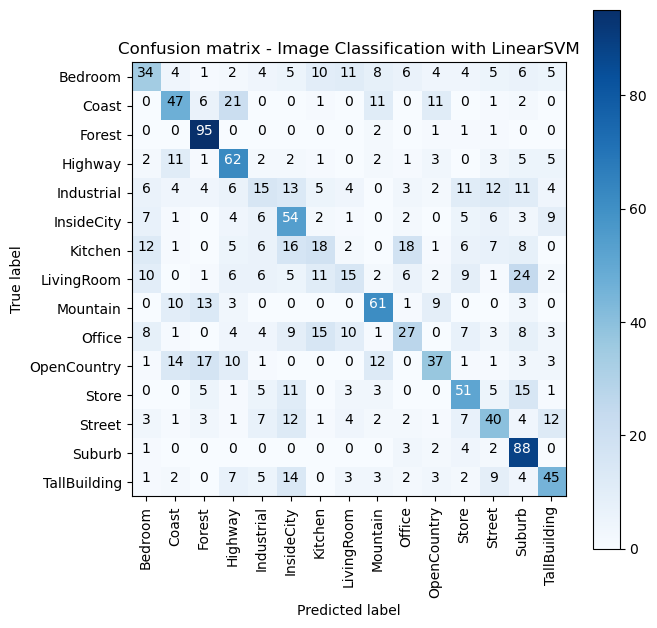

In [15]:
# Best Model Classification
best_model = LinearSVC(C=optimizer.max['params']['C'], max_iter = int(optimizer.max['params']['max_iter']))
best_model.fit(train_encoded_features, y_train)
y_pred = best_model.predict(test_encoded_features)

# Confusion matrix 계산
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix , classes=labels_names, 
                      title='Confusion matrix - Image Classification with LinearSVM')

In [16]:
# 오분류된 이미지들의 인덱스 찾기
misclassified_indices = np.where(y_test != y_pred)[0]

# 오분류된 각 이미지에 대해
for index in misclassified_indices:
    # 이미지 불러오기
    misclassified_image = x_test[index]
    
    # 실제 레이블과 예측 레이블 가져오기
    true_label = labels_names[y_test[index]]
    predicted_label = labels_names[y_pred[index]]
    
    # 이미지 이름 설정
    image_name = f"./result_images/LinearSVM/{true_label}_{predicted_label}.png"
    
    # 이미지 저장
    cv2.imwrite(image_name, misclassified_image)

In [24]:
# confusion matrix를 numpy array로 변환
cnf_matrix = np.array(cnf_matrix)

# 각 라벨별 정확도를 저장할 빈 딕셔너리 생성
accuracy_per_label = {}

# 각 라벨에 대해
for i, label_name in enumerate(labels_names):
    # true positive 계산
    tp = cnf_matrix[i, i]
    
    # 라벨별 샘플 수 계산
    total_samples_for_label = np.sum(cnf_matrix[i, :])
    
    # 정확도 계산
    accuracy = tp / total_samples_for_label
    
    # 딕셔너리에 정확도 저장
    accuracy_per_label[label_name] = accuracy

# 결과 출력
print("[Accuracy_per_label]")
for label, accuracy in accuracy_per_label.items():
    print(f"{label:<20} {format(accuracy, '.2f')}")

[Accuracy_per_label]
Bedroom              0.31
Coast                0.47
Forest               0.95
Highway              0.62
Industrial           0.15
InsideCity           0.54
Kitchen              0.18
LivingRoom           0.15
Mountain             0.61
Office               0.27
OpenCountry          0.37
Store                0.51
Street               0.40
Suburb               0.88
TallBuilding         0.45


SVM외 다른 classifier 
- Sklearn 패키지 내 classifier : SVC(kernel=‘poly’), GradientBoosting, RandomForest
- Sklearn 패키지 외 classifier : XGB, LightGBM
- SVM(kernel-poly): 커널은 고차원으로 데이터를 매핑하여 선형적인 형태로 만드는 방법. Poly 커널은 주로 비선형 데이터를 분류할 때 사용
- Gradient Boosting: 여러 결정 트리를 이전 트리의 오차를 보완하는 방식으로 학습하면서 모델 향상
- Random Forest: 여러 개의 결정 트리를 독립적으로 학습하고, 결과를 평균 내어 예측을 수행
- XGBoost: Gradient Boosting 알고리즘 기반, 병렬 처리 사용, 과적합 방지를 위한 정규화 적용
- LightGBM: Gradient Boosting 알고리즘 기반, 트리 균형을 맞추지 않고 손실 최소화하는 리프 노드 우선적 분할

<br/>트리 기반 classifier(GradientBoosting, RandomForest, XGB, LightGBM)가 과적합되는 경향이 큼 <br/>
: 이미지 데이터는 고차원적이고 복잡한 패턴을 가지는 경우가 많음. 트리 기반 classifier의 경우, 복잡한 패턴을 학습하려고 할 때, 과적합 발생 쉬움<br/>
: 트리 기반 classifier는 비교적 많은 양의 데이터가 학습에 필요. 현재 사용하는 이미지 데이터셋이 충분하지 않을 경우 과적합이 발생.
<br/><br/>비교적 높은 평가 점수를 가진 SVC(kernel=‘poly’), LightGBM을 다음 평가에서 사용함.


In [13]:
# Parameters
patch_stride = 32
K = 40

# Load Dataset
def scene15():
    train_folders = glob.glob("./SCENE-15/train/*")
    train_folders.sort()
    classes = dict()
    x_train = list()
    y_train = list()
    for index, folder in enumerate(train_folders):
        label = os.path.basename(folder)
        classes[label] = index
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_train.append(cv2.imread(path, 0))
            y_train.append(index)

    x_test = list()
    y_test = list()
    test_folders = glob.glob("./SCENE-15/test/*")
    test_folders.sort()
    for folder in test_folders:
        label = os.path.basename(folder)
        index = classes[label]
        paths = glob.glob(os.path.join(folder, "*"))
        for path in paths:
            x_test.append(cv2.imread(path, 0))
            y_test.append(index)
    return x_train, y_train, x_test, y_test, sorted(classes.keys())

print("Load Dataset ...")
x_train, y_train, x_test, y_test, labels_names = scene15()
random_indices = list(range(len(y_train)))
random.shuffle(random_indices)
x_train = np.array(x_train, dtype=object)[random_indices].tolist()
y_train = np.array(y_train, dtype=object)[random_indices].tolist()

# Extract Patches
train_key_points = list()
train_feature_shapes = list()
for image in x_train:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    train_key_points.append(image_key_points)
    train_feature_shapes.append((len(range(0, w, patch_stride)), 
                                 (len(range(0, h, patch_stride)))))

test_key_points = list()
test_feature_shapes = list()
for image in x_test:
    h, w = image.shape
    image_key_points = list()
    for x in range(0, w, patch_stride):
        for y in range(0, h, patch_stride):
            image_key_points.append(cv2.KeyPoint(x, y, patch_stride))
    test_key_points.append(image_key_points)
    test_feature_shapes.append((len(range(0, w, patch_stride)), 
                                (len(range(0, h, patch_stride)))))

# SIFT: Extract Features
def SIFT(image):
    # SIFT 객체 생성
    sift= cv2.xfeatures2d.SIFT_create()
    # 키포인트,디스크립터 추출
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

train_features = list()
index = 0
for image, key_points in zip(x_train, train_key_points):
    _, features = SIFT(image)
    train_features.append(features)
    index += 1
    # print("Extract Train Features ... {:4d}/{:4d}".format(index, len(x_train)))

test_features = list()
index = 0
for image, key_points in zip(x_test, test_key_points):
    _, features = SIFT(image)
    test_features.append(features)
    index += 1
    # print("Extract Test Features ... {:4d}/{:4d}".format(index, len(x_test)))

# Normalizing
flattened_train_features = np.concatenate(train_features, axis=0)
pca = PCA(n_components=flattened_train_features.shape[-1], whiten=True)
pca.fit(flattened_train_features)
train_normalized_features = list()
index = 0
for features in train_features:
    features = pca.transform(features)
    train_normalized_features.append(features)
    index += 1
    # print("Normalize Train Features ... {:4d}/{:4d}".format(index, len(train_features)))
test_normalized_features = list()
index = 0
for features in test_features:
    features = pca.transform(features)
    test_normalized_features.append(features)
    index += 1
    # print("Normalize Test Features ... {:4d}/{:4d}".format(index, len(test_features)))

# Make Codebook
class Codebook:
    
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K, n_init=10, verbose=False)

    def make_code_words(self, features):
        self.kmeans.fit(features)

    def encode_1(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # np.argmin을 사용하여 가장 가까운 centroid 찾음
        nearest_centroid_indices = np.argmin(distances, axis=1)
        # 각 centroid에 대해 one-hot encoding을 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용하여 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

    def encode_2(self, features, shapes):
        distances = self.kmeans.transform(features)
        representations = np.zeros(dtype=np.int64, shape=(len(distances), self.K))
        # scikit-learn의 KMeans.predict 사용, 가장 가까운 centroid를 찾음
        nearest_centroid_indices = self.kmeans.predict(features)
        # 각 centroid에 대해 one-hot encoding 적용
        representations[np.arange(len(distances)), nearest_centroid_indices] = 1
        # np.sum을 사용 각 centroid의 빈도 계산
        representations = np.sum(representations, axis=0)

        if np.array(representations).shape != (self.K, ):
            print(np.array(representations).shape)
            print("Your code may be wrong")

        return representations

print("Make Codebook ...")
flattened_normalized_train_features = pca.transform(flattened_train_features)
codebook = Codebook(K)
codebook.make_code_words(flattened_normalized_train_features)

# Encode Features
train_encoded_features = list()
index = 0
for features, shapes in zip(train_normalized_features, train_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    train_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Train Features ... {:4d}/{:4d}".format(index, len(train_normalized_features)))
test_encoded_features = list()
index = 0
for features, shapes in zip(test_normalized_features, test_feature_shapes):
    encoded_features = codebook.encode_2(features, shapes)
    test_encoded_features.append(encoded_features)
    index += 1
    # print("Encoding Text Features ... {:4d}/{:4d}".format(index, len(test_normalized_features)))

train_encoded_features = np.array(train_encoded_features)
train_encoded_features = np.vstack(train_encoded_features)
test_encoded_features = np.array(test_encoded_features)
test_encoded_features = np.vstack(test_encoded_features)

# Approximate Kernel
chi2sampler = AdditiveChi2Sampler(sample_steps=2)
chi2sampler.fit(train_encoded_features, y_train)
train_encoded_features = chi2sampler.transform(train_encoded_features)
test_encoded_features = chi2sampler.transform(test_encoded_features)

Load Dataset ...
Make Codebook ...


Classifier: SVC(kernel='poly'), GradientBoosting, RandomForest, XGB, LightGBM

In [14]:
model = SVC(kernel='poly')
start_time = time.time()
print("Classify Images ...(SVC(kernel='poly'))")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)
elapsed_time = time.time() - start_time

# 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Classify Images ...(SVC(kernel='poly'))
Train  Score: 0.68726
Test   Score: 0.43738
Elapsed Time: 0.38 secs


In [15]:
model = GradientBoostingClassifier()
start_time = time.time()
print("Classify Images ...(GradientBoosting)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)
elapsed_time = time.time() - start_time

# 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Classify Images ...(GradientBoosting)
Train  Score: 0.98830
Test   Score: 0.42545
Elapsed Time: 7.35 secs


In [16]:
model = RandomForestClassifier()
start_time = time.time()
print("Classify Images ...(RandomForest)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)
elapsed_time = time.time() - start_time

# 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Classify Images ...(RandomForest)
Train  Score: 1.00000
Test   Score: 0.42810
Elapsed Time: 0.24 secs


In [17]:
model = XGBClassifier()
start_time = time.time()
print("Classify Images ...(XGB)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)
elapsed_time = time.time() - start_time

# 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Classify Images ...(XGB)
Train  Score: 1.00000
Test   Score: 0.42611
Elapsed Time: 3.10 secs


In [18]:
model = LGBMClassifier(verbose=-1)
start_time = time.time()
print("Classify Images ...(LGBM)")
model.fit(train_encoded_features, y_train)
train_score = model.score(train_encoded_features, y_train)
test_score = model.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# 학습 결과 출력
print("=" * 90)
print("Train  Score: {:.5f}".format(train_score))
print("Test   Score: {:.5f}".format(test_score))
print("Elapsed Time: {:.2f} secs".format(elapsed_time))
print("=" * 90)

Classify Images ...(LGBM)
Train  Score: 1.00000
Test   Score: 0.43406
Elapsed Time: 4.22 secs


베이지안 최적화: SVC(poly), LightGBM

SVM(kernel=poly) 파라미터
- C: 소프트 마진 크기. 값이 크면 마진 오류를 허용하지 않기 때문에 과적합 초래. 반면, 값이 작으면 마진 오류를 더 많이 허용하기 때문에 과소적합 초래. 
- gamma: 값이 크면 결정 경계 복잡해짐. 반면, 값이 작으면 결정 경계가 단순해짐
- degree: poly 커널에서 사용되는 파라미터로 다항식 차수를 결정. 값이 크면 다항식 커널이 더 복잡한 형태를 가지기 때문에  과적합 초래.


LightGBM 파라미터
- num_leaves: 트리가 가질 수 있는 최대 잎의 수. 값이 크면 모델의 복잡성이 증가하면서 과적합 될 수 있음.
- max_depth: 트리의 최대 깊이. 모델의 복잡성 제어
- min_child_samples: 노드(잎)에 있어야 하는 최소 데이터 수. 트리가 더 이상 분할되지 않도록 하는 역할로, 과적합 제어.
- learning_rate: 학습률로, 각 트리의 영향력 조정. 일반적으로 작은 값을 사용하면 더 많은 트리가 필요하지만, 성능 좋아짐
- n_estimators: 사용할 트리의 수. 값이 크면 모델의 복잡성이 증가하면서 과적합 될 수 있음.


In [37]:
# 최적화할 SVC(ploy)hyperparameter
search_space = {
    'C': (1e-6, 1e+6, 'log-uniform'), 
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'degree': (1,10)
}

# 베이지안 최적화기 초기화
opt = BayesSearchCV(
    SVC(kernel='poly', verbose=False),
    search_space,
    n_iter=10,
    cv=5,
    random_state=1
)

start_time = time.time()

# 모델 최적화
opt.fit(train_encoded_features, y_train)

# 최적화 모델 결과 점수 계산
train_score = opt.score(train_encoded_features, y_train)
test_score = opt.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time
# best score, best parameters 출력
print("=" * 90)
print("Best score: {:.5f}".format(opt.best_score_))
best_params = opt.best_params_
print("Best C: {:.5f}, Best gamma: {:.5f}, Best degree: {:.0f}".format(best_params['C'],best_params['gamma'], best_params['degree']))
print("=" * 90)

Best score: 0.45710
Best C: 270.23395, Best gamma: 0.00043, Best degree: 2


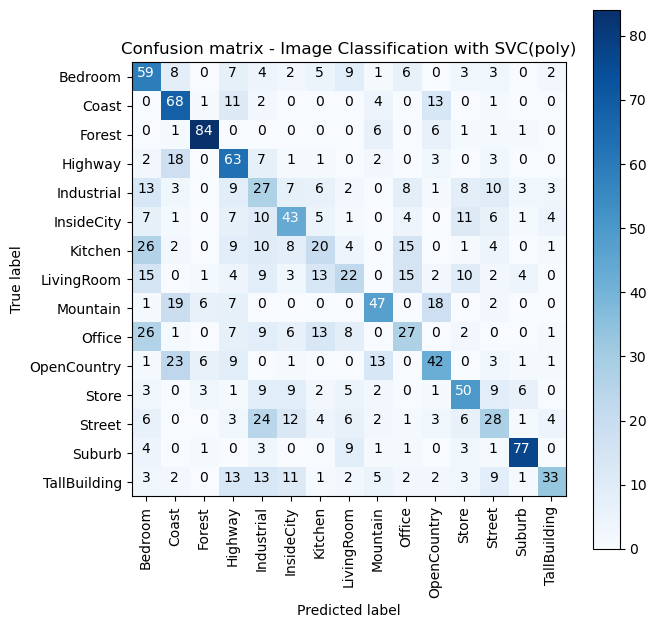

In [39]:
# SVC(ploy) best parameters
best_model = SVC(kernel='poly',
    C=best_params['C'],
    gamma=best_params['gamma'],
    degree=int(best_params['degree']),
    random_state=1
)

# SVC(ploy) best model
best_model.fit(train_encoded_features, y_train)
y_pred = best_model.predict(test_encoded_features)

# Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix , classes=labels_names, 
                      title='Confusion matrix - Image Classification with SVC(poly)')

In [40]:
# confusion matrix를 numpy array로 변환
cnf_matrix = np.array(cnf_matrix)

# 각 라벨별 정확도를 저장할 빈 딕셔너리 생성
accuracy_per_label = {}

# 각 라벨에 대해
for i, label_name in enumerate(labels_names):
    # true positive 계산
    tp = cnf_matrix[i, i]
    
    # 라벨별 샘플 수 계산
    total_samples_for_label = np.sum(cnf_matrix[i, :])
    
    # 정확도 계산
    accuracy = tp / total_samples_for_label
    
    # 딕셔너리에 정확도 저장
    accuracy_per_label[label_name] = accuracy

# 결과 출력
print("[Accuracy_per_label]")
for label, accuracy in accuracy_per_label.items():
    print(f"{label:<20} {format(accuracy, '.2f')}")

[Accuracy_per_label]
Bedroom              0.54
Coast                0.68
Forest               0.84
Highway              0.63
Industrial           0.27
InsideCity           0.43
Kitchen              0.20
LivingRoom           0.22
Mountain             0.47
Office               0.27
OpenCountry          0.42
Store                0.50
Street               0.28
Suburb               0.77
TallBuilding         0.33


In [47]:
# 최적화할 LightGBM hyperparameters
search_space = {
    'num_leaves': (5, 500), 
    'min_child_samples': (5, 500), 
    'max_depth': (5, 20),
    'learning_rate': (0.01, 0.5, 'log-uniform'),
    'n_estimators': (5, 300),
}

# 베이지안 최적화기 초기화
opt = BayesSearchCV(
    LGBMClassifier(verbose=-1),
    search_space,
    n_iter=10,
    cv=5,
    random_state=1
)

start_time = time.time()

# 모델 최적화
opt.fit(train_encoded_features, y_train)

# 최적화 모델 결과 점수 계산
train_score = opt.score(train_encoded_features, y_train)
test_score = opt.score(test_encoded_features, y_test)

elapsed_time = time.time() - start_time

# best score, best parameters 출력
print("=" * 90)
print("Best score: {:.5f}".format(opt.best_score_))
best_params = opt.best_params_

print("Best learning_rate: {:.5f}".format(best_params['learning_rate']))
print("Best max_depth: {:.0f}".format(best_params['max_depth']))
print("Best min_child_samples: {:.0f}".format(best_params['min_child_samples']))
print("Best n_estimators: {:.0f}".format(best_params['n_estimators']))
print("Best num_leaves: {:.0f}".format(best_params['num_leaves']))
print("=" * 90)

Best score: 0.46622
Best learning_rate: 0.14499
Best max_depth: 10
Best min_child_samples: 20
Best n_estimators: 133
Best num_leaves: 205


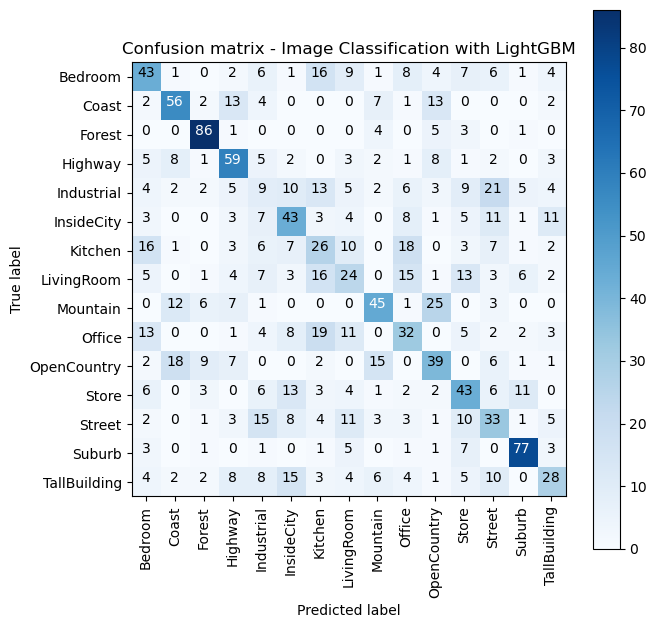

In [42]:
# LightGBM best parameters
best_model = LGBMClassifier(verbose=-1,
    num_leaves=int(best_params['num_leaves']),
    min_child_samples=int(best_params['min_child_samples']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    random_state=1
)

# LightGBM best model
best_model.fit(train_encoded_features, y_train)
y_pred = best_model.predict(test_encoded_features)


# Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix , classes=labels_names, 
                      title='Confusion matrix - Image Classification with LightGBM')

In [45]:
# confusion matrix를 numpy array로 변환
cnf_matrix = np.array(cnf_matrix)

# 각 라벨별 정확도를 저장할 빈 딕셔너리 생성
accuracy_per_label = {}

# 각 라벨에 대해
for i, label_name in enumerate(labels_names):
    # true positive 계산
    tp = cnf_matrix[i, i]
    
    # 라벨별 샘플 수 계산
    total_samples_for_label = np.sum(cnf_matrix[i, :])
    
    # 정확도 계산
    accuracy = tp / total_samples_for_label
    
    # 딕셔너리에 정확도 저장
    accuracy_per_label[label_name] = accuracy

# 결과 출력
print("[Accuracy_per_label]")
for label, accuracy in accuracy_per_label.items():
    print(f"{label:<20} {format(accuracy, '.2f')}")

[Accuracy_per_label]
Bedroom              0.39
Coast                0.56
Forest               0.86
Highway              0.59
Industrial           0.09
InsideCity           0.43
Kitchen              0.26
LivingRoom           0.24
Mountain             0.45
Office               0.32
OpenCountry          0.39
Store                0.43
Street               0.33
Suburb               0.77
TallBuilding         0.28
